In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns',None)
df = pd.read_csv("C:/Users/User/Downloads/diabetes_prediction_dataset.csv")
df = df[df['gender'] != 'Other']
df.drop_duplicates(inplace=True)
def age_stage(age):
    if age<=1:                    # Infants(0-1)
        return 'Infant'         
    elif age<=12:                 # Children(2-12)
        return 'Child'
    elif age<=19:                 # Teenagers(13-19)
        return 'Teenager'
    elif age<=24:                 # Youths(20-24)
        return 'Youth'
    elif age<=64:                 # Adults(25-64)
        return 'Adult'
    else:                         # Seniors(65 years and over)
        return 'Senior'
df['age_stage'] = df['age'].apply(age_stage)
def outlier_detection(Column):
    Q3 = df[Column].quantile(0.75)
    Q1 = df[Column].quantile(0.25)
    IQR = Q3-Q1
    Up_Lim = Q3+1.5*IQR
    Low_Lim = Q1-1.5*IQR
    num = len(df[(df[Column]>Up_Lim)|(df[Column]<Low_Lim)])
def outlier_capping(column):
    x = df[column]
    q3 = df[column].quantile(0.75)
    q1 = df[column].quantile(0.25)
    iqr = q3-q1
    upper_limit = q3+1.5*iqr
    lower_limit = q1-1.5*iqr
    df[column] = np.where(df[column]>upper_limit,upper_limit,
                          np.where(df[column]<lower_limit,lower_limit,df[column]))
outlier_capping('bmi')
outlier_capping('HbA1c_level')
outlier_capping('blood_glucose_level')

In [2]:
df.sample(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_stage
35624,Female,66.0,0,0,No Info,33.30,4.5,85.0,0,Senior
28548,Female,63.0,0,0,former,16.56,5.7,158.0,0,Adult
67427,Female,65.0,0,0,never,23.00,6.5,126.0,0,Senior
11080,Female,21.0,0,0,never,27.32,5.8,100.0,0,Youth
49660,Male,18.0,0,0,No Info,33.17,6.0,126.0,0,Teenager
20005,Female,17.0,0,0,never,27.32,6.2,90.0,0,Teenager
6938,Female,80.0,0,0,current,20.70,6.6,155.0,0,Senior
31363,Female,18.0,0,0,never,22.84,6.1,160.0,0,Teenager
62298,Female,37.0,0,0,former,25.68,5.8,80.0,0,Adult
79776,Female,58.0,0,0,never,28.87,6.0,159.0,0,Adult


In [3]:
# necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

0    87646
1     8482
Name: diabetes, dtype: int64
Note: Imabalanced Data


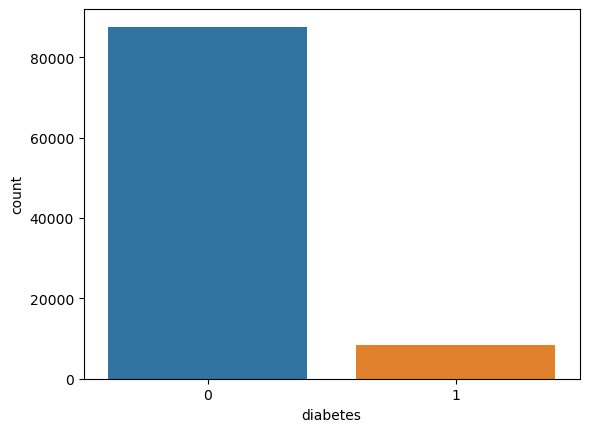

In [4]:
print(df.diabetes.value_counts())
sns.countplot(x=df.diabetes)
print("Note: Imabalanced Data")

In [5]:
X = df.drop('diabetes',axis=1)     # features
y = df['diabetes']                 # target variable

# transformer 1
trf1 = ColumnTransformer(transformers=[
    ('ohe',OneHotEncoder(sparse=False),[0,4,8])
],remainder='passthrough')

# transformer 2
trf2 = ColumnTransformer(transformers=[
    ('scaling',StandardScaler(),slice(0,21))
],remainder='passthrough')

# building pipeline
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2)])

# split up X,y
Xtrain, Xtest, ytrain, ytest = train_test_split(X , y , random_state=65, stratify=df.diabetes)

# transform data
Xtrain_fit = pipe.fit_transform(Xtrain)
Xtest_fit =  pipe.transform(Xtest)

# pipeline workflow
pipe

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  [0, 4, 8])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  slice(0, 21, None))]))])

# Model  with imbalanced data

In [6]:
# time count for model building
import time
start = time.time()

In [7]:
import imblearn
from collections import Counter

# distribution of target class in actual data
Counter(y)

Counter({0: 87646, 1: 8482})

n_nb: 4 max score: 0.9582223701731025


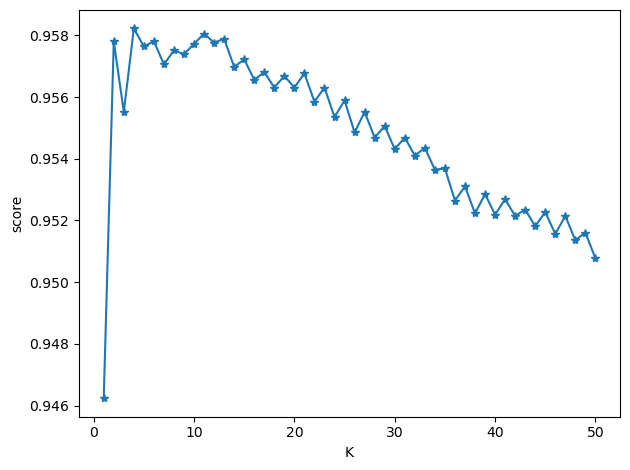

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
score = []
n_nb = []
for k in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain_fit,ytrain)
    y_pred = knn.predict(Xtest_fit)
    score.append(accuracy_score(ytest,y_pred))
    n_nb.append(k)
print( 'n_nb:',n_nb[score.index(max(score))],'max score:',max(score))
plt.plot(n_nb,score,'*-')
plt.xlabel('K')
plt.ylabel("score")
plt.tight_layout()

In [9]:
Knn = KNeighborsClassifier(n_neighbors=n_nb[score.index(max(score))])
Knn.fit(Xtrain_fit,ytrain)
y_pred = Knn.predict(Xtest_fit)
accuracy_score(ytest,y_pred)

0.9582223701731025

In [10]:
conf_matrix = metrics.confusion_matrix(ytest,y_pred)
confusion_matrix = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
display(confusion_matrix)
print(classification_report(ytest,y_pred))

,Predicted 0,Predicted 1
Actual 0,21814,98
Actual 1,906,1214


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21912
           1       0.93      0.57      0.71      2120

    accuracy                           0.96     24032
   macro avg       0.94      0.78      0.84     24032
weighted avg       0.96      0.96      0.95     24032



# Models with balanced data 

In [11]:
# function for balancing data 
def resampled_model(resampler):
    #global Xtest_fit, Xtest_fit, ytrain, ytest_, n_neigh
    X_fit = pipe.fit_transform(X)
    x_res,y_res = resampler.fit_resample(X_fit,y)
    print("distribution of target class after resampling")
    print(Counter(y_res))

    Xtrain, Xtest, ytrain, ytest = train_test_split(x_res , y_res , test_size=0.30, random_state=35, stratify=y_res.values)
    # transform data
    #Xtrain_fit = pipe.fit_transform(Xtrain)
    #Xtest_fit =  pipe.transform(Xtest)
    # empty lists for storing scores and n_nb
    score = []
    n_nb = []
    for k in range(1,51):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(Xtrain,ytrain)
        ypred = knn.predict(Xtest)
        score.append(accuracy_score(ytest,ypred))
        n_nb.append(k)
    n_neigh = n_nb[score.index(max(score))]
    print( 'neighbours:',n_neigh,'max score:',max(score))
    
    Knn = KNeighborsClassifier(n_neighbors=n_neigh)
    Knn.fit(Xtrain,ytrain)
    print(Knn)
    y_pred = Knn.predict(Xtest)
    print("Accuracy Score: ",accuracy_score(ytest,y_pred))
    conf_matrix = metrics.confusion_matrix(ytest,y_pred)
    confusion_matrix = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    display(confusion_matrix)
    print("Classification Report")
    print(classification_report(ytest,y_pred))
    

### UnderSampling - random approach

In [12]:
from imblearn.under_sampling import RandomUnderSampler
resampled_model(RandomUnderSampler())

distribution of target class after resampling
Counter({0: 8482, 1: 8482})
neighbours: 21 max score: 0.8823182711198428
KNeighborsClassifier(n_neighbors=21)
Accuracy Score:  0.8823182711198428


,Predicted 0,Predicted 1
Actual 0,2193,352
Actual 1,247,2298


Classification Report
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2545
           1       0.87      0.90      0.88      2545

    accuracy                           0.88      5090
   macro avg       0.88      0.88      0.88      5090
weighted avg       0.88      0.88      0.88      5090



### UnderSampling - centroid approach

In [13]:
from imblearn.under_sampling import ClusterCentroids
resampled_model(ClusterCentroids())

distribution of target class after resampling
Counter({0: 8482, 1: 8482})
neighbours: 14 max score: 0.8563850687622789
KNeighborsClassifier(n_neighbors=14)
Accuracy Score:  0.8563850687622789


,Predicted 0,Predicted 1
Actual 0,2131,414
Actual 1,317,2228


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2545
           1       0.84      0.88      0.86      2545

    accuracy                           0.86      5090
   macro avg       0.86      0.86      0.86      5090
weighted avg       0.86      0.86      0.86      5090



### UnderSampling - ENN

In [14]:
from imblearn.under_sampling import EditedNearestNeighbours
resampled_model(EditedNearestNeighbours())

distribution of target class after resampling
Counter({0: 81518, 1: 8482})
neighbours: 1 max score: 0.974037037037037
KNeighborsClassifier(n_neighbors=1)
Accuracy Score:  0.974037037037037


,Predicted 0,Predicted 1
Actual 0,24307,148
Actual 1,553,1992


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     24455
           1       0.93      0.78      0.85      2545

    accuracy                           0.97     27000
   macro avg       0.95      0.89      0.92     27000
weighted avg       0.97      0.97      0.97     27000



### OverSampling - random approach

In [15]:
from imblearn.over_sampling import RandomOverSampler
resampled_model(RandomOverSampler())

distribution of target class after resampling
Counter({0: 87646, 1: 87646})
neighbours: 1 max score: 0.9810413021982202
KNeighborsClassifier(n_neighbors=1)
Accuracy Score:  0.9810413021982202


,Predicted 0,Predicted 1
Actual 0,25330,964
Actual 1,33,26261


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     26294
           1       0.96      1.00      0.98     26294

    accuracy                           0.98     52588
   macro avg       0.98      0.98      0.98     52588
weighted avg       0.98      0.98      0.98     52588



### OverSampling - SMOTE

In [16]:
from imblearn.over_sampling import SMOTE
resampled_model(SMOTE())

distribution of target class after resampling
Counter({0: 87646, 1: 87646})
neighbours: 1 max score: 0.9599718566973454
KNeighborsClassifier(n_neighbors=1)
Accuracy Score:  0.9599718566973454


,Predicted 0,Predicted 1
Actual 0,24753,1541
Actual 1,564,25730


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     26294
           1       0.94      0.98      0.96     26294

    accuracy                           0.96     52588
   macro avg       0.96      0.96      0.96     52588
weighted avg       0.96      0.96      0.96     52588



### Mix of UnderSampling and OverSampling - SMOTEENN

In [17]:
from imblearn.combine import SMOTEENN
resampled_model(SMOTEENN())

distribution of target class after resampling
Counter({1: 82141, 0: 77997})
neighbours: 1 max score: 0.996482244702552
KNeighborsClassifier(n_neighbors=1)
Accuracy Score:  0.996482244702552


,Predicted 0,Predicted 1
Actual 0,23253,146
Actual 1,23,24620


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     23399
           1       0.99      1.00      1.00     24643

    accuracy                           1.00     48042
   macro avg       1.00      1.00      1.00     48042
weighted avg       1.00      1.00      1.00     48042



### Elapsed time

In [18]:
elapsed_time = time.time()-start
print(elapsed_time/60," Minutes")

55.19553201993306  Minutes


# Conclusion

Data set is imbalanced and majority class is 0 i.e non diabetic. At first model is developed with imbalanced data and found very low recall for class 1 i.e diabetic . Since, model creates a large number of type-1 error, which may very serious matter in this case. Thus, model performance is considered in terms of recall for class 1 .
Keeping this in mind, some data balancing techniques like RandomUnderSampler, ClusterCentroids, EditedNearestNeighbours,  RandomOverSampler, SMOTE, SMOTEENN are performed to reduce type-1 error and increase recall for class 1 .